In [1]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
import ray
ray.shutdown()
ray.init()

system = 'team'

2021-03-27 12:35:37,581	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8269


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path

system_folder = str(Path.cwd().parent / files['system folder'])

raw_data_csv = str(Path.cwd().parent / files['raw data'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])

processed_data_csv = str(Path.cwd().parent / files['single setting preprocessing'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'Shows the number of files for every label, from JabRef')

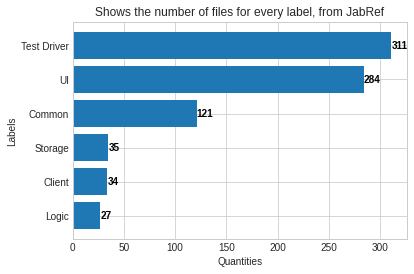

In [5]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('Shows the number of files for every label, from JabRef')

----

# Evaluation

### Static parts
__Train-test split,__ will be set at 10% for training, and 90% for evaluation.  
* __Metrics,__ the most relevant ones will be the following:  
   * Confusion matrix  
   * Precission  
   * Accuracy  
   * F1-score/value  
   * Average score 
    
----

# TEST

In [6]:
setting = preprocess_settings['s0']
Prep.preprocess_settings(setting, raw_data_csv, processed_data_csv)

,FileName,Label,FileContent
0,RemoteApiClient.java,Client,"[io, ioexcept, com, googl, appengin, tool, rem..."
1,package-info.java,Client,"[teammates, client, remoteapi]"
2,LoopHelper.java,Client,"[teammates, client, scripts, util]"
3,Stopwatch.java,Client,"[teammates, client, scripts, util]"
4,package-info.java,Client,"[teammates, client, scripts, util]"
...,...,...,...
807,FeedbackResultsResponseTable.java,UI,"[util, list, teammates, ui, template]"
808,StudentProfile.java,UI,"[teammat, common, datatransf, attribut, studen..."
809,StudentProfileEditBox.java,UI,"[util, list, teammat, common, datatransf, attr..."
810,package-info.java,UI,"[teammates, ui, template]"


In [7]:
test_df = pd.read_csv(processed_data_csv)
# Remove GLOBALS and CLI from the dataset
df_sliced = Utils.remove_concerns_under_quantity_threshold(test_df)
test_size=0.9
fold_quantity = 10
feature_representation = CountVectorizer()
confusion_list = []

# Train and gather evaluation metrics
evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
classifier_svm , metrics_svm = evaluate.evaluate_SVM()
classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()

metrics = {
    'maxEnt': metrics_max_ent,
    'SVM': metrics_svm,
    'Naive': metrics_naive
}

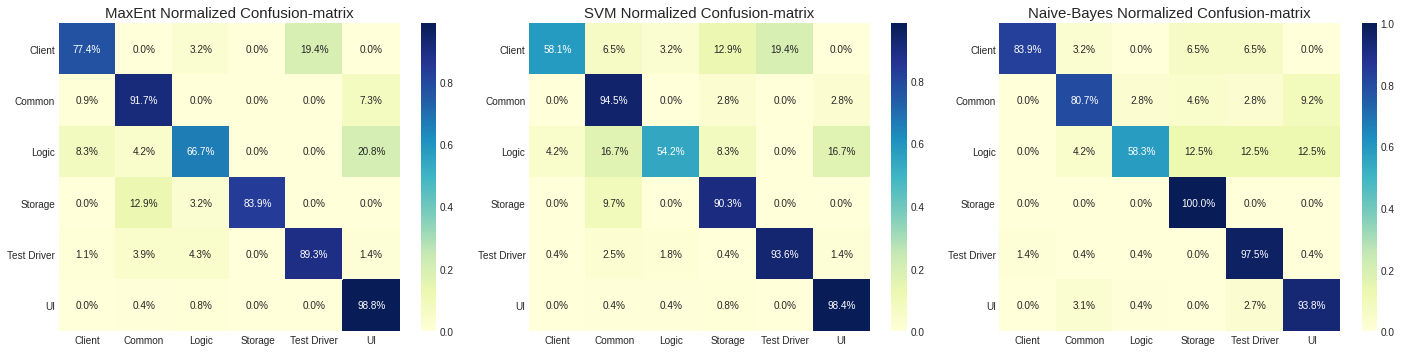

In [8]:
Graphs.plot_horizontal_graphs(metrics, 'norm')

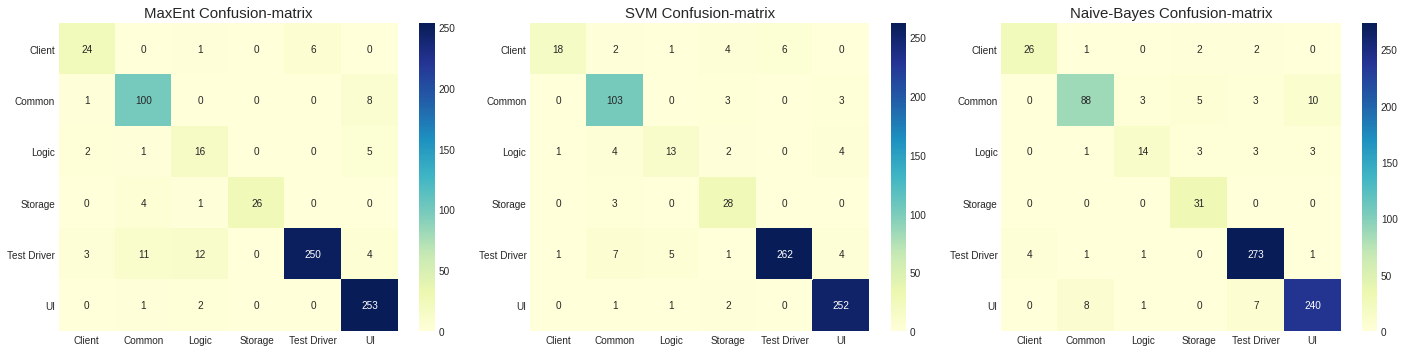

In [9]:
Graphs.plot_horizontal_graphs(metrics, 'regular')

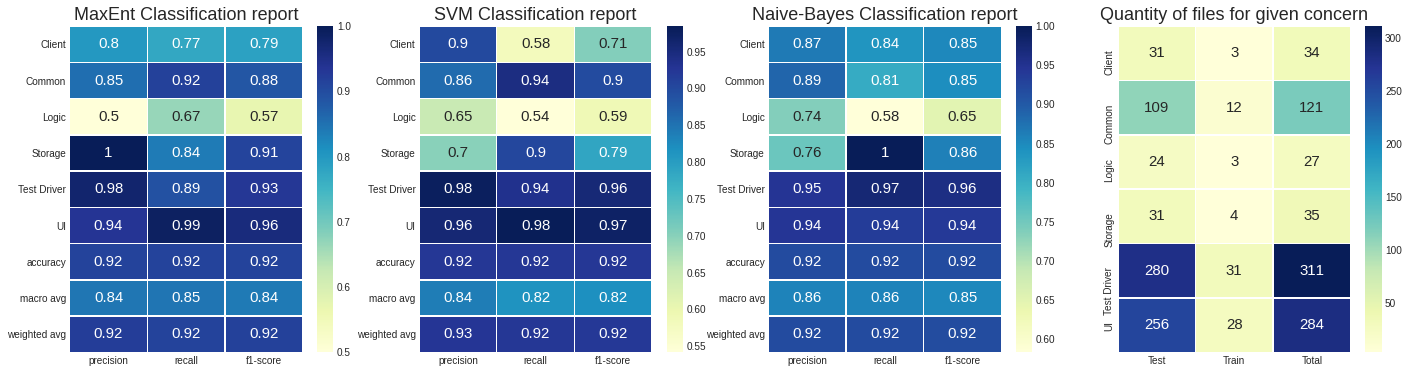

<Figure size 432x288 with 0 Axes>

In [10]:
Graphs.plot_horizontal_graphs(metrics, 'report')

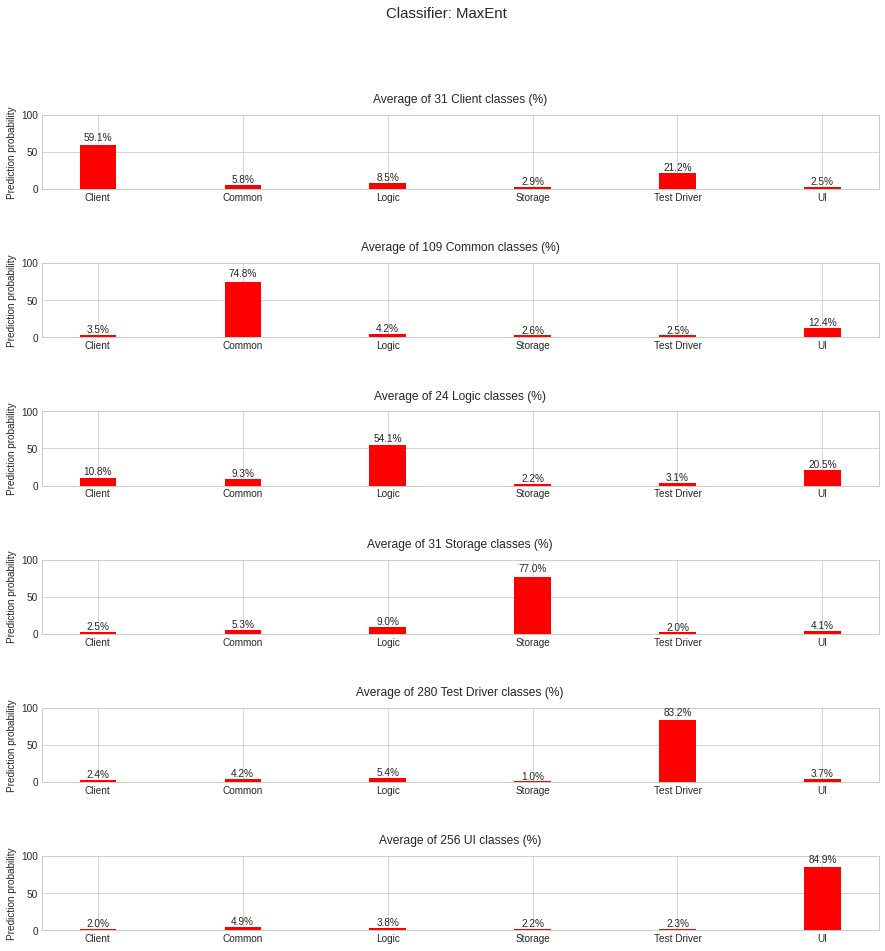

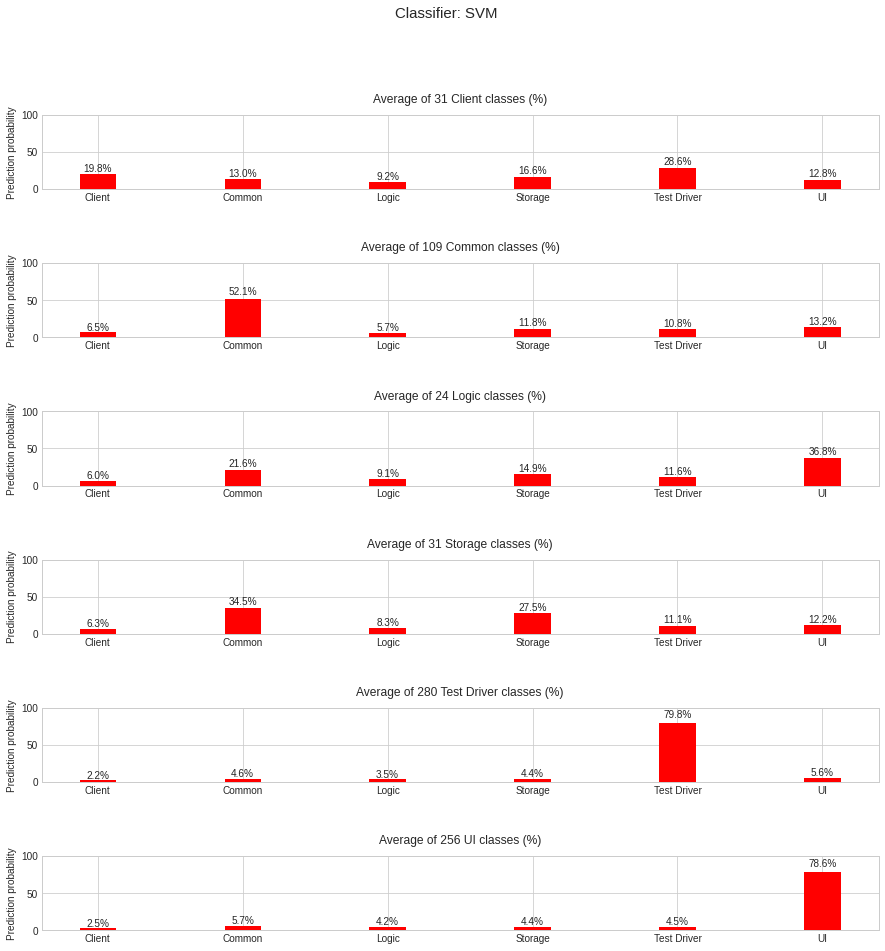

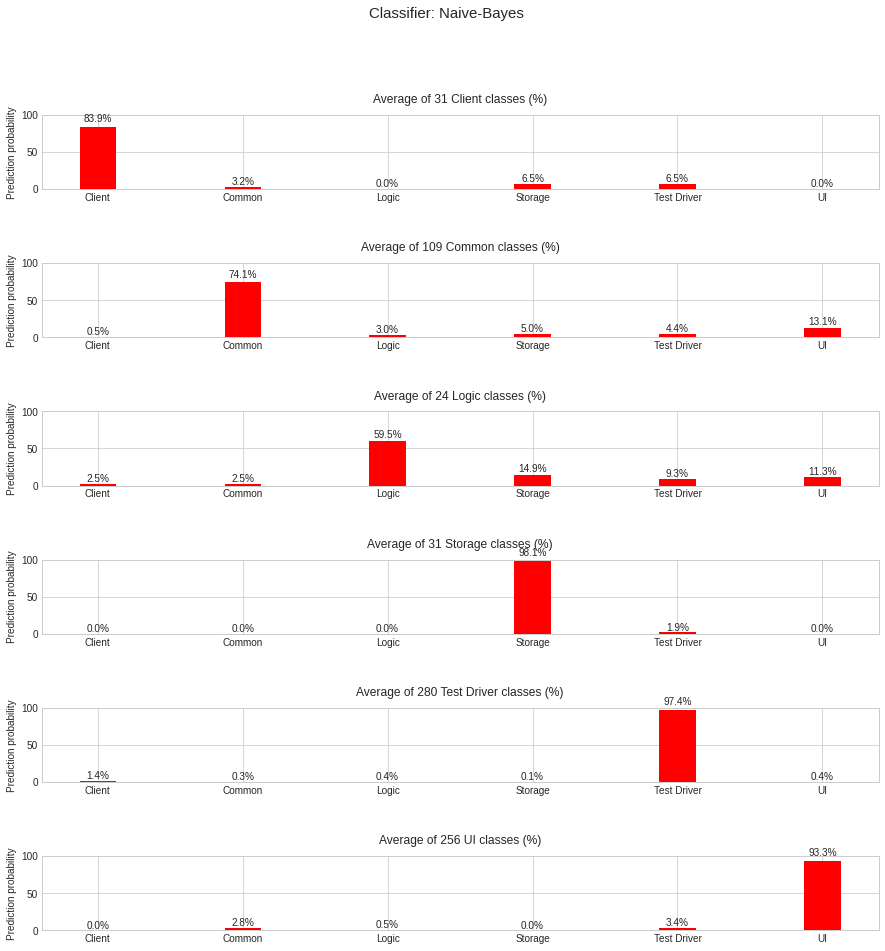

In [11]:
Graphs.plot_predictionScoreAverage(metrics_max_ent, classifier_max_ent)
Graphs.plot_predictionScoreAverage(metrics_svm, classifier_svm)
Graphs.plot_predictionScoreAverage(metrics_naive, classifier_naive)

In [12]:
df = metrics_svm.total_report_table()
df

,Client,Common,Logic,Storage,Test Driver,UI,accuracy,macro avg,weighted avg
precision,0.900000,0.858333,0.650000,0.700000,0.977612,0.958175,0.924761,0.840687,0.927199
recall,0.580645,0.944954,0.541667,0.903226,0.935714,0.984375,0.924761,0.815097,0.924761
f1-score,0.705882,0.899563,0.590909,0.788732,0.956204,0.971098,0.924761,0.818732,0.923264
support,31.000000,109.000000,24.000000,31.000000,280.000000,256.000000,0.924761,731.000000,731.000000
Test,31.000000,109.000000,24.000000,31.000000,280.000000,256.000000,NaN,NaN,NaN
Train,3.000000,12.000000,3.000000,4.000000,31.000000,28.000000,NaN,NaN,NaN
Total,34.000000,121.000000,27.000000,35.000000,311.000000,284.000000,NaN,NaN,NaN
